In [1]:
import os
import numpy as np
import pandas as pd
import torch

from tifffile import imread
from fastai import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.metrics import error_rate

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [3]:
# create df
df_cell = pd.DataFrame()
dir_cell = '/media/iana/cebra/training_refinement/1174/cells'
cells = [x for x in os.listdir(dir_cell) if x.endswith('Ch0.tif')][:50]
df_cell['im_name'] = cells
df_cell['dir'] = dir_cell
df_cell['ann'] = 'cell'

df_n_cell = pd.DataFrame()
dir_n_cell = '/media/iana/cebra/training_refinement/1174/non_cells'
non_cells = [x for x in os.listdir(dir_n_cell) if x.endswith('Ch0.tif')][:50]
df_n_cell['im_name'] = non_cells
df_n_cell['dir'] = dir_n_cell
df_n_cell['ann'] = 'non_cell'

data_sel = pd.concat([df_cell, df_n_cell], ignore_index=True)

In [4]:
data_sel

,im_name,dir,ann
0,pCellz336y3449x3495Ch0.tif,/media/iana/cebra/training_refinement/1174/cells,cell
1,pCellz336y3208x3559Ch0.tif,/media/iana/cebra/training_refinement/1174/cells,cell
2,pCellz336y1776x1486Ch0.tif,/media/iana/cebra/training_refinement/1174/cells,cell
3,pCellz336y2530x411Ch0.tif,/media/iana/cebra/training_refinement/1174/cells,cell
4,pCellz336y2678x2459Ch0.tif,/media/iana/cebra/training_refinement/1174/cells,cell
...,...,...,...
95,pCellz338y5227x2407Ch0.tif,/media/iana/cebra/training_refinement/1174/non_cells,non_cell
96,pCellz338y2710x410Ch0.tif,/media/iana/cebra/training_refinement/1174/non_cells,non_cell
97,pCellz338y4754x1343Ch0.tif,/media/iana/cebra/training_refinement/1174/non_cells,non_cell
98,pCellz338y2205x472Ch0.tif,/media/iana/cebra/training_refinement/1174/non_cells,non_cell


## Train the model

In [5]:
def get_x(r): 
    
    im_path = os.path.join(r.dir,r.im_name)
    return im_path

def get_y(r): return r['ann']

In [6]:
def int2float(o:TensorImage):
    return o.float().div_(2**16)

class ImageND(Tuple):
    @classmethod
    def create(cls, array_file): 
        #return cls(tuple(PILImage.create(f) for f in image_files))

        '''
        # version for numpy arrays
        nd_image = np.load(array_file)
        nd_image = np.concatenate([nd_image[0,:,:,:],nd_image[1,:,:,:]],axis=2)
        '''
        # version for tiff files
        nd_image = imread(array_file)
        nd_image = nd_image.astype(float)
        nd_image = tensor(nd_image)

        return nd_image

def ImageNDBlock(): 
    return TransformBlock(type_tfms  = ImageND.create,
                          batch_tfms = int2float)

In [7]:
dblock = DataBlock(blocks    = (ImageNDBlock, CategoryBlock),
                   get_x = get_x,
                   get_y = get_y,
                   splitter = RandomSplitter(valid_pct=0.1))

In [8]:
dsets = dblock.datasets(data_sel)

In [9]:
dsets.vocab

['cell', 'non_cell']

In [10]:
# create dataloaders

dls = dblock.dataloaders(data_sel)

In [11]:
# create a visualization function

def show_nd_batch(max_n=4):
    xb, yb = dls.one_batch()
    fig, axes = plt.subplots(ncols=4, nrows=int(max_n/4), figsize=(12,12))
    for i in range(max_n):
        axes[i%4,int(i/4)].imshow(xb[i][10,:,:].cpu().numpy())
        axes[i%4,int(i/4)].set_title(dsets.vocab[yb[i].cpu().item()])
        axes[i%4,int(i/4)].axis('off')

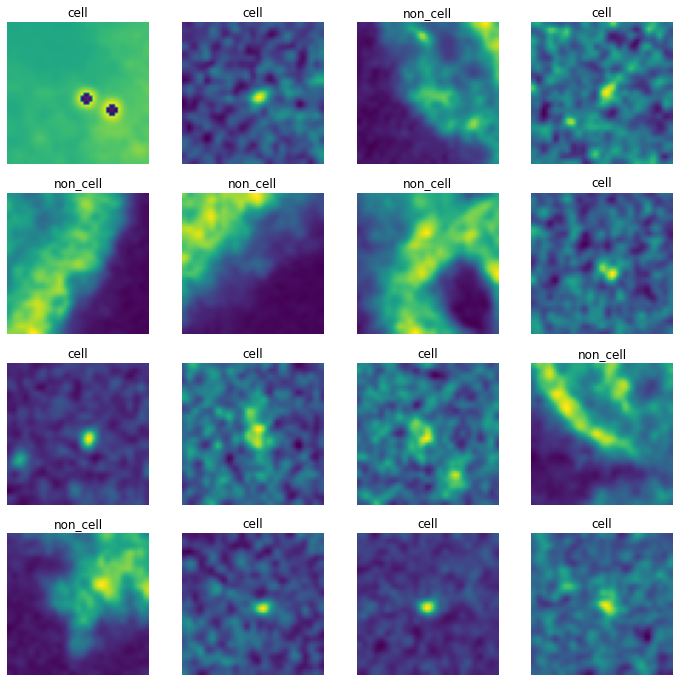

In [12]:
# visualize a batch
show_nd_batch(max_n=16)

In [13]:
# create a learner
learn = vision_learner(dls, resnet50, metrics=error_rate)

/home/iana/anaconda3/envs/fastai-env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/iana/anaconda3/envs/fastai-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
nChannels=20
learn.model[0][0]=nn.Conv2d(nChannels,64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [15]:
learn.load('/CBI_Hive/CBI/Iana/projects/cebra/fastai_training/model_1093_0966_0954_0828')

/home/iana/anaconda3/envs/fastai-env/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


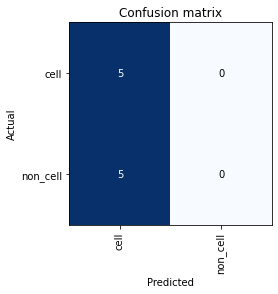

In [16]:
# check initial status of the learner
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))

In [17]:
# freeze early layers
learn.freeze()

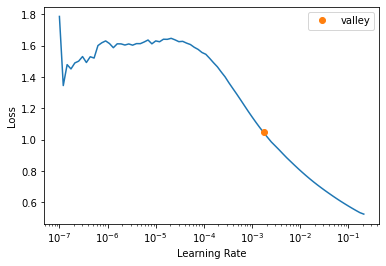

In [18]:
# find starting learning rate
res = learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,1.257012,0.648744,0.300000,00:02
1,1.263692,0.381565,0.200000,00:02
2,1.033782,0.190854,0.100000,00:02
3,0.870335,0.059753,0.000000,00:02
4,0.721243,0.027018,0.000000,00:02
5,0.605750,0.021443,0.000000,00:02
6,0.516271,0.016288,0.000000,00:02
7,0.454222,0.012990,0.000000,00:03
8,0.403977,0.012046,0.000000,00:02
9,0.364967,0.010290,0.000000,00:03


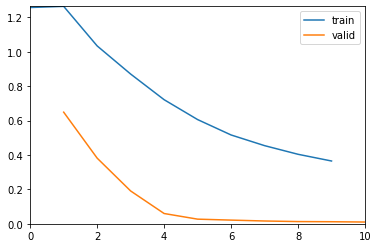

In [19]:
learn.fit_one_cycle(10, res.valley, cbs=[ShowGraphCallback()])

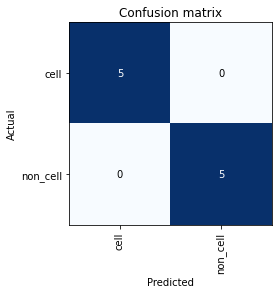

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))

In [21]:
# # that function requires plotting so has to be re-implemented for 3D images
# interp.plot_top_losses(9)

In [22]:
learn.unfreeze()

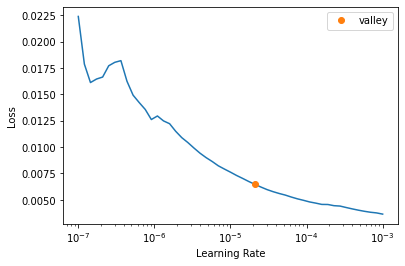

In [23]:
# find starting learning rate
res = learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,0.025673,0.009771,0.000000,00:02
1,0.024153,0.008432,0.000000,00:02
2,0.016671,0.008692,0.000000,00:02


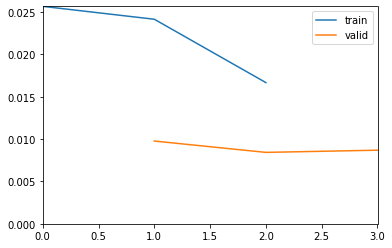

In [24]:
learn.fit_one_cycle(3, res.valley, cbs=[ShowGraphCallback()])

## Save the trained model

In [25]:
learn.save('/CBI_Hive/CBI/Iana/projects/cebra/fastai_training/refinement/1174/model_1093_0966_0954_828_1174', with_opt=False)
# learn.save('/CBI_Hive/CBI/Iana/projects/cebra/fastai_training/refinement/1174/model_1174', with_opt=False)

Path('/CBI_Hive/CBI/Iana/projects/cebra/fastai_training/refinement/1174/model_1093_0966_0954_828_1174.pth')